# 欠損値補間のロジスティック回帰

http://machine-learning.hatenablog.com/entry/2017/08/30/221801

In [1]:
!date

2019年 8月21日 水曜日 21時45分30秒 JST


In [2]:
%matplotlib inline
%matplotlib nbagg

import warnings
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# Data

In [3]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [4]:
# Settings
D = 2
N = 30

# Sample parameters
Sigma_w = np.eye(D) * 20.0
W = np.random.multivariate_normal(np.zeros(D), Sigma_w)

# Data
sigma_x = 1.0
X_raw = 2 * np.random.rand(2, N) - 1.0
Y = np.random.binomial(1, sigmoid(np.dot(W, X_raw)))

#### 欠損値の生成

In [5]:
rate = 0.50
X = deepcopy(X_raw)
for i in range(D):
    for j in range(N):
        X[i, j] = None if np.random.rand() < rate else X[i, j]

#### 欠損していない値の抜き出し

In [6]:
idx = ~np.isnan(X).any(axis=0)
X_red = X[:, idx]
Y_red = Y[idx]

#### Plot

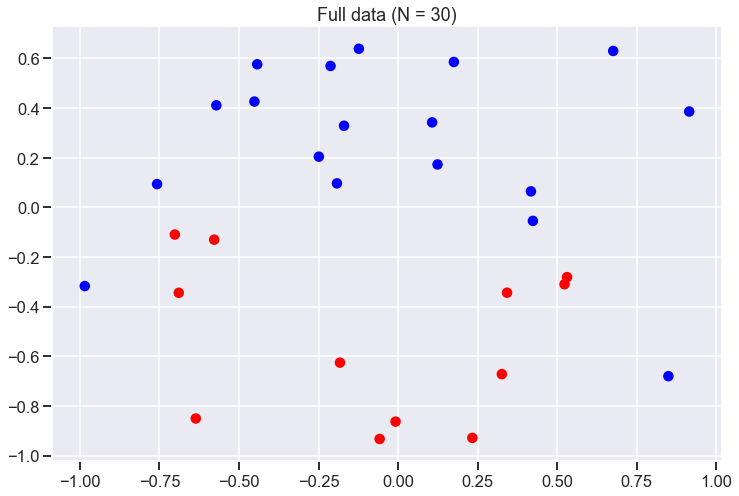

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(X_raw[0], X_raw[1], color=[['b', 'r'][v] for v in Y])
plt.title('Full data (N = 30)')
plt.show()

# Inference

In [8]:
def insert_x(x, x_miss):
    ret = deepcopy(x)
    ret[np.isnan(ret)] = x_miss
    return ret

In [9]:
def unnormalized_log_posterior(W, Y, X, Sigma_w, sigma_x):
    """
    Unnormalized log posterior ln(p*(z))

    p(Y|w, X) = Bern(y_n|sigmoid(w * x_n)) (n=1...N)
    p(w) = N(w|0, sigma_w)
    p(X) = N(x_n,d|0, sigma_x) (n=1...N)

    return ln p(Y|w, X) + ln p(w) + ln p(X)
    """

    lkh = np.sum(Y * np.log(sigmoid(np.dot(W, X)))
                 + (1 - Y) * np.log(1 - sigmoid(np.dot(W, X))))
    pri_w = -0.5 * np.dot(np.dot(W, np.linalg.inv(Sigma_w)), W)
    pri_x = -0.5 * (np.sum(X ** 2) * (sigma_x * 2) ** -1)

    return lkh + pri_w + pri_x

In [10]:
def MetropolitanHastings(Y, X, Sigma_w, sigma_x, sigma_mh, 
                         num_results, num_burnin):
    """
    Metropolitan Hastings
    """

    # Settings
    M = len(X)
    N_miss = np.sum(np.isnan(X))
    
    # Initialize
    W = np.random.randn(M)
    X_miss = np.random.randn(N_miss)
    
    # Array for results
    samples_W = np.zeros((M, num_results))
    samples_X = np.zeros((N_miss, num_results))
    
    # Sampling
    for i in range(num_results):
        # Sample W
        W_new = np.random.multivariate_normal(W, sigma_mh ** 2 * np.eye(M))
        X_tmp = insert_x(X, X_miss)
        r = np.exp(np.min([unnormalized_log_posterior(W_new, Y, X_tmp, Sigma_w, sigma_x)
                           - unnormalized_log_posterior(W, Y, X_tmp, Sigma_w, sigma_x), 0]))
        W = W_new if np.random.rand() < r else W
        samples_W[:, i] = W
        
        # Sample X_miss
        if N_miss == 0:
            continue
    
        X_miss_new = np.random.multivariate_normal(X_miss, sigma_mh ** 2 * np.eye(N_miss))
        X_tmp1 = insert_x(X, X_miss_new)
        X_tmp2 = insert_x(X, X_miss)
        r = np.exp(np.min([unnormalized_log_posterior(W, Y, X_tmp1, Sigma_w, sigma_x)
                           - unnormalized_log_posterior(W, Y, X_tmp2, Sigma_w, sigma_x), 0]))
        X_miss = X_miss_new if np.random.rand() < r else X_miss
        samples_X[:, i] = X_miss
        
    return samples_W, samples_X

In [11]:
sigma_mh = 0.10
num_results = 4000
num_burnin = 1000

# Sample for small data
samples_W1, samples_X1 = MetropolitanHastings(Y_red, X_red, Sigma_w, sigma_x, sigma_mh,
                                              num_results, num_burnin)

# Sample for missing data
samples_W2, samples_X2 = MetropolitanHastings(Y, X, Sigma_w, sigma_x, sigma_mh,
                                              num_results, num_burnin)

# Sample for raw (original) data
samples_W3, samples_X3 = MetropolitanHastings(Y, X_raw, Sigma_w, sigma_x, sigma_mh,
                                              num_results, num_burnin)

# Plot

In [12]:
def plot_contour(samples_W, X, Y, title):
    # Prepare x&y axis
    res = 100
    x_min = np.nanmin(X[0])
    x_max = np.nanmax(X[0])
    y_min = np.nanmin(X[1])
    y_max = np.nanmax(X[1])
    
    x_min -= 0.5 * (x_max - x_min)
    x_max += 0.5 * (x_max - x_min)
    x_min -= 0.5 * (y_max - y_min)
    x_max += 0.5 * (y_max - y_min)
    
    x1 = np.linspace(x_min, x_max, res)
    x2 = np.linspace(y_min, y_max, res)
    x_grid, y_grid = np.meshgrid(x1, x2)
    val = np.array([x_grid.flatten(), y_grid.flatten()])
    
    # z axis
    z_list = []
    for n in range(samples_W1.shape[1]):
        W = samples_W[:, n]
        z_list.append(sigmoid(np.dot(W, val)))
        
    z_grid = np.array(z_list).mean(axis=0).reshape((res, res))
    
    # Plot
    plt.contour(x_grid, y_grid, z_grid, alpha=0.5, cmap='bwr')
    plt.scatter(X[0], X[1], color=[['b', 'r'][v] for v in Y])
    plt.title(title)

In [13]:
# Estimated missing values
X_est = insert_x(X, samples_X2.mean(axis=1))
X_std = deepcopy(X) * 0
X_std = insert_x(X_std, samples_X2.std(axis=1))

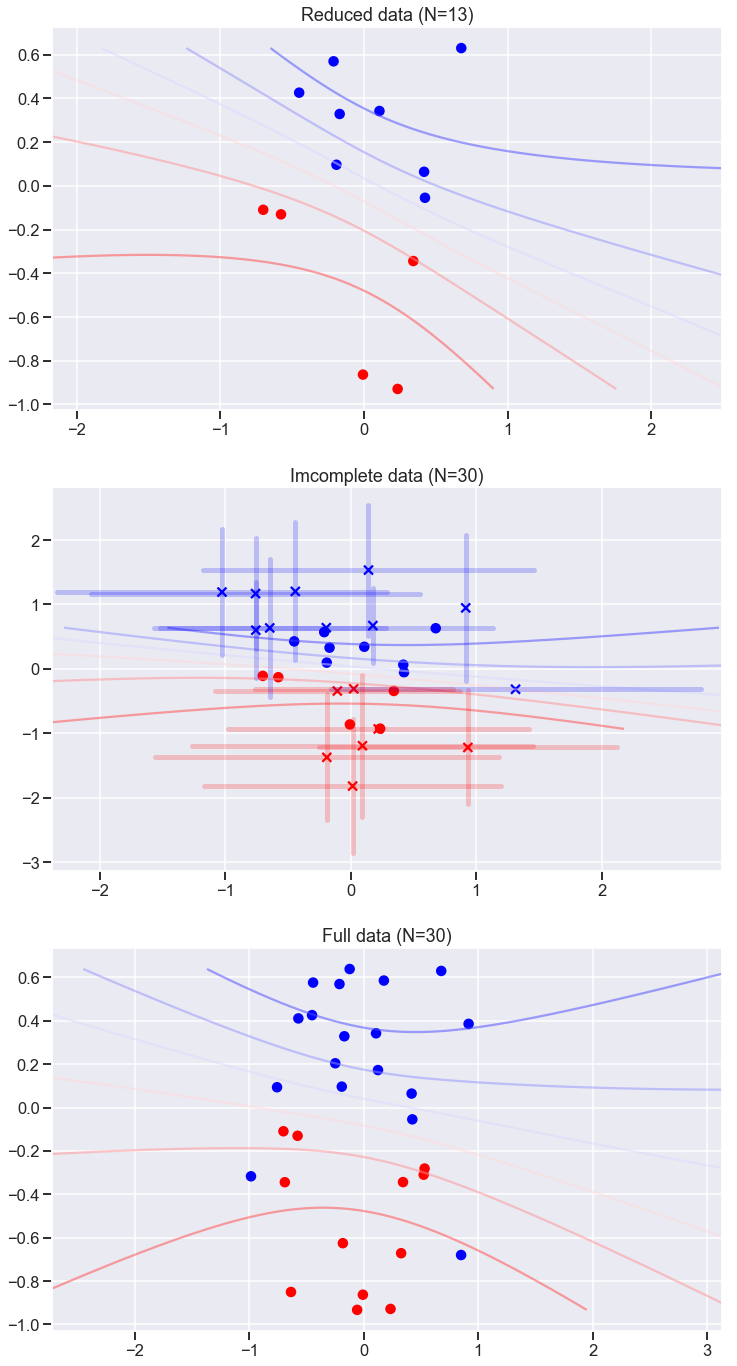

In [14]:
plt.figure(figsize=(12, 24))

plt.subplot(311)
plot_contour(samples_W1, X_red, Y_red, f'Reduced data (N={len(Y_red)})')

plt.subplot(312)

# Plot missing values
plt.scatter(X_est[0, ~idx], X_est[1, ~idx], marker='x', color=[['b', 'r'][v] for v in Y[~idx]])

# Error bar
for i, v in enumerate(idx):
    if not v:
        plt.plot([X_est[0, i] - X_std[0, i], X_est[0, i] + X_std[0, i]], [X_est[1, i], X_est[1, i]], 
                 color=['b', 'r'][Y[i]], alpha=0.2, lw=5)
        plt.plot([X_est[0, i], X_est[0, i]], [X_est[1, i] - X_std[1, i], X_est[1, i] + X_std[1, i]], 
                 color=['b', 'r'][Y[i]], alpha=0.2, lw=5)

plot_contour(samples_W2, X, Y, f'Imcomplete data (N={N})')

plt.subplot(313)
plot_contour(samples_W3, X_raw, Y, f'Full data (N={N})')

plt.show()